# Semi-Supervised Learning

In this notebook we want to explore the semi-supervided algorithm presented [Eldad Haber](https://eldad-haber.webnode.com/) in the [BMS Summer School 2019: Mathematics of Deep Learning](https://www.math-berlin.de/academics/summer-schools/2019), during 19 - 30 August 2019, at the Zuse Institute Berlin. He developed an implementation in Matlab which you can find in [this](https://github.com/eldadHaber/CompAI/) GitHub repository. In addition, please find the corresponding slides [here](https://github.com/eldadHaber/CompAI/blob/master/02-SemiSup.pdf).

## Prepare Notebook


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Generate Sample Data 

Let us generate the sample data as 3 concentric circles:

In [2]:
def generate_circle_sample_data(r, n, sigma):
    """Generates circle data with random gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y

In [3]:
# Number of classes.
n_c = 3
# Number of samples per class (without label).
n_c_samples = 500
# Radius grid. 
r1, r2, r3 = 2, 4, 6
# Noise standard deviation. 
sigma = 0.4

x1, y1 = generate_circle_sample_data(r1, n_c_samples, sigma)
x2, y2 = generate_circle_sample_data(r2, n_c_samples, sigma)
x3, y3 = generate_circle_sample_data(r3, n_c_samples, sigma)

Let us plot the sample data:

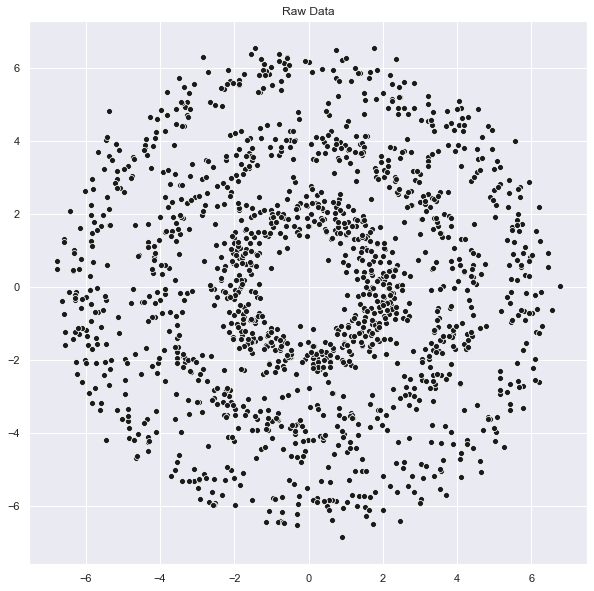

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k')
sns.scatterplot(x=x2, y=y2, ax=ax, color='k')
sns.scatterplot(x=x3, y=y3, ax=ax, color='k')

ax.set(title='Raw Data');

## Add Labeled Data 

Now we generate some labeled samples:

In [5]:
# Set number of labeled samples per class.
n_c_ex = 20
# Total number of labeled samples. 
n_ex = n_c*n_c_ex
# Generate labeled data.
q1, p1 = generate_circle_sample_data(2, n_c_ex, sigma)
q2, p2 = generate_circle_sample_data(4, n_c_ex, sigma)
q3, p3 = generate_circle_sample_data(6, n_c_ex, sigma)

Let us plot the complete data set:

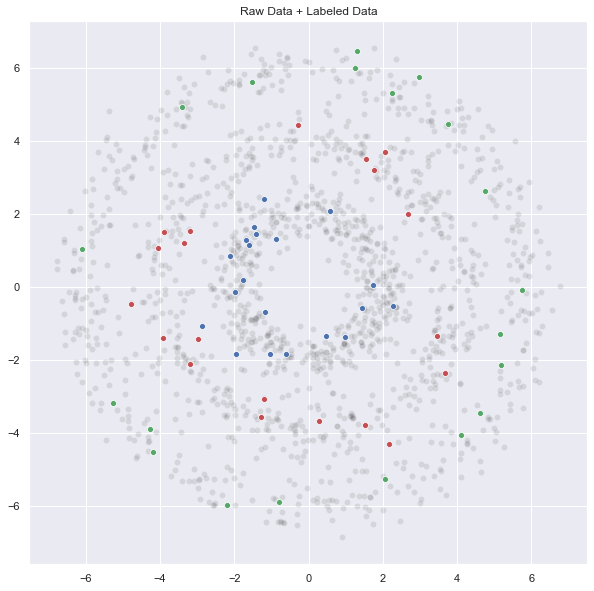

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=x1, y=y1, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x2, y=y2, ax=ax, color='k', alpha=0.1)
sns.scatterplot(x=x3, y=y3, ax=ax, color='k', alpha=0.1)

sns.scatterplot(x=q1, y=p1, ax=ax, color='b')
sns.scatterplot(x=q2, y=p2, ax=ax, color='r')
sns.scatterplot(x=q3, y=p3, ax=ax, color='g')

ax.set(title='Raw Data + Labeled Data');

In [7]:
# Merge Data  
x = np.concatenate([x1, x2, x3, q1, q2, q3]).reshape(-1, 1)
y = np.concatenate([y1, y2, y3, p1, p2, p3]).reshape(-1, 1)

data_matrix = np.concatenate([x, y], axis=1)

Le tus compute the total number of points in the data set:

In [8]:
n = data_matrix.shape[0]
n

1560

In [9]:
# Common sense check:
n == n_c*(n_c_samples + n_c_ex)

True

## Generate Adjacency Matrix

In the same spirit as in the blog post [PyData Berlin 2018: On Laplacian Eigenmaps for Dimensionality Reduction](https://juanitorduz.github.io/laplacian_eigenmaps_dim_red/), we consider the adjacency matrix associated to the graph constructed from the data using the $k$-nearest neighbors. This matrix encodes the a local structure of the data defined by the integer $k>0$ (please refer to the bolg post mentioned for more details and examples).

In [10]:
from sklearn.neighbors import kneighbors_graph

# Set nearest neighbors used to compute the graph.
nn = 7
# We store the as a sparse matrix.
adjacency_matrix_s = kneighbors_graph(X=data_matrix,n_neighbors=nn)

Let us plot the adjacency matrix:

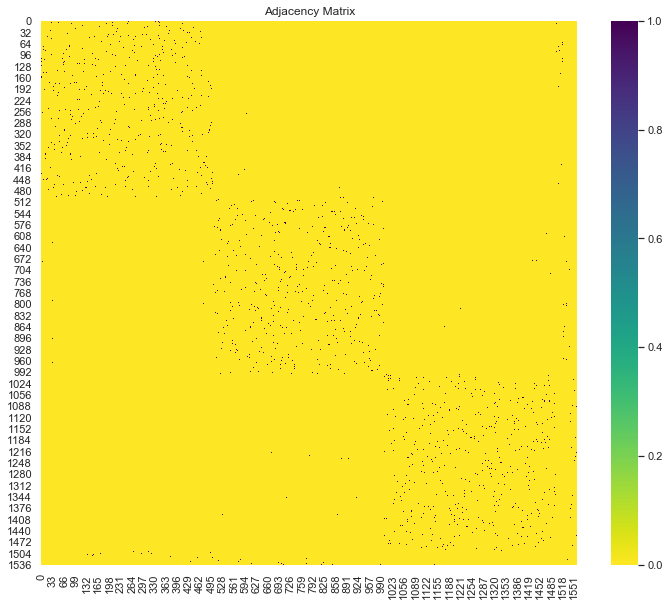

In [11]:
from scipy import sparse

# Convert to numpy array'
adjacency_matrix = adjacency_matrix_s.toarray()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(adjacency_matrix, ax=ax, cmap='viridis_r')
ax.set(title='Adjacency Matrix');

As the data was not not shuffled, we can see the "cluster" blocks. We also see the three small groups of labeled data on the right column.

## Generate Graph Laplacian

Next, we compute the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix), 

$$L = D - A$$

where $A$ and $D$ are the adjacency matrix and the degree matrix of the graph respectively.

In [12]:
graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)

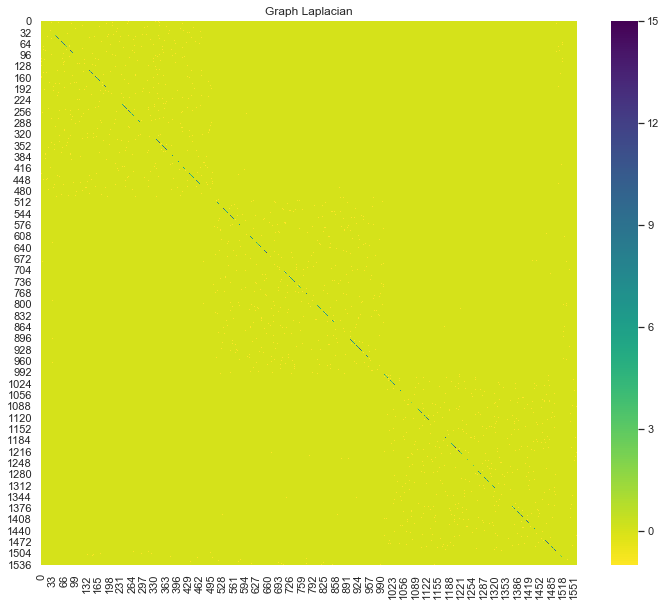

In [13]:
graph_laplacian = graph_laplacian_s.toarray()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

## Learning Problem Description

Following the [exposition](https://github.com/eldadHaber/CompAI/blob/master/02-SemiSup.pdf) of [Eldad Haber](https://eldad-haber.webnode.com/), the loss function we want to minimize is:

$$
\min_{U}\mathcal{E}(U) = \min_{U} \left(\text{loss}(U, U_{obs}) + \frac{\alpha}{2} \text{tr}(U^T L U)\right)
$$

where 

- $\text{loss}(U, U_{obs})$ is the cost function associated with the labels (see details below). 

- $\frac{\alpha}{2} \text{tr}(U^T L U)$ encodes the locality property: *close points should be similar* (to see this go to [The Algorithm](https://juanitorduz.github.io/documents/orduz_pydata2018.pdf) section of my PyData presentation). In Haber's words: *Try to find the non-constant vector with the minimal energy. The solution should be "smooth" on the graph.*

- The constant $\alpha>0$ is controls the contriibution of these two components of the cost function. 


## Construct Loss Function

- One-Hot Encoding of the labels

In [14]:
u_obs = np.zeros(shape=(n_ex, n_c))

# Encode the known labels for each class. 
u_obs[0:n_c_ex, 0] = 1
u_obs[n_c_ex:2*n_c_ex, 1] = 1
u_obs[2*n_c_ex:3*n_c_ex, 2] = 1

u_obs.shape

(60, 3)

In [15]:
# Get index of labeled data.
label_index = np.arange(start=n_c*n_c_samples, stop=n)

In [16]:
# We define a function to project onto the labeled labels.
def project_to_labeled(u, label_index):
    """Project matrix into the set of labeled data."""
    return u[label_index, :]

- Softmax Loss

We define a function which computes the softmax loss functions of a vector of labels `u_obs`. Here the distance function is the cross entropy 

$$
\text{loss}(U, U_{obs}) = - \frac{1}{m} U^T_{obs} \log(\text{softmax(U}))
$$

where $m$ is the number of labeled data points and 

$$
\text{softmax}(z) = \frac{\exp(z)}{\sum \exp(z)}
$$

In [17]:
from scipy.special import softmax

def sofmax_loss(c, c_obs):
    """Computes the softmax loss function of two vectors."""
    m = c.shape[0]
    
    soft_max = np.apply_along_axis(softmax, axis=1, arr=c)
    # Add small epsilon for numerical stability.
    loss = - (1/m)*np.dot(c_obs.T, np.log(soft_max + 0.001))

    loss = np.trace(loss)
    
    return loss

- Laplacian Loss

In [18]:
def laplacial_loss(c, graph_laplacian):
    """Loss function associated to the graph Laplacian."""
    loss = 0.5*np.dot(c.T, np.dot(graph_laplacian, c))
    
    loss = np.trace(loss)
    
    return loss

In [19]:
def loss(u, u_obs, label_index, graph_laplacian, alpha):
    """Loss function of the semi-supervised algorithm based 
    on the graph Laplacian. 
    """
    u_proj = project_to_labeled(u, label_index)
    
    loss = sofmax_loss(u_proj, u_obs) + (alpha/2)*laplacial_loss(u, graph_laplacian)
    
    return loss

## Run Optimizer

Next, we simply run an optimizer to find a solution for out problem. 

**Warning:** This is done just for illustration purposes. This step must not be overlooked in applications. For example, in [this](https://github.com/eldadHaber/CompAI/blob/master/matlabCode/semiSuperLearn.m) Matlab code the solution is found using inexact Newton"s method. 

In [20]:
from scipy.optimize import minimize

# Define initial estimate.
u0 = np.ones(shape=(n, n_c)) / 0.5

# Run optimizer.
optimizer_result = minimize(
    fun = lambda x: loss(x.reshape(n, n_c), u_obs, label_index, graph_laplacian, 1.0), 
    x0=u0.flatten()
)

## Predict Classes 

Finally, let us see the predicted classes:

In [21]:
# Get best parameter. 
u_best = optimizer_result.x.reshape(n, n_c) 
# Compute classes 
u_best_softmax = np.apply_along_axis(softmax, axis=1, arr=u_best)
u_pred = np.argmax(a=u_best_softmax, axis=1)

In [22]:
# Store in a dataframe. 
data_df = pd.DataFrame(data_matrix, columns=['x', 'y'])
# Add one to have class labels starting form one. 
data_df['pred_class'] = u_pred + 1
# Store as categorical variable. 
data_df['pred_class'] = data_df['pred_class'].astype('category')

data_df.head()

,x,y,pred_class
0,2.131937,-0.026668,1
1,-1.873468,0.788236,1
2,2.353201,-0.567092,1
3,-0.046962,2.220652,1
4,0.667804,-2.905643,2


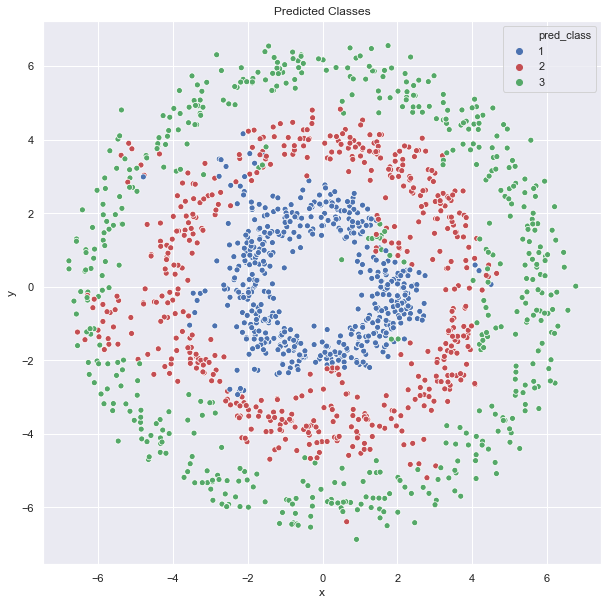

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
    x='x', 
    y='y', 
    data=data_df, 
    hue='pred_class', 
    palette=['b', 'r', 'g'],
    ax=ax
)

ax.set(title='Predicted Classes');

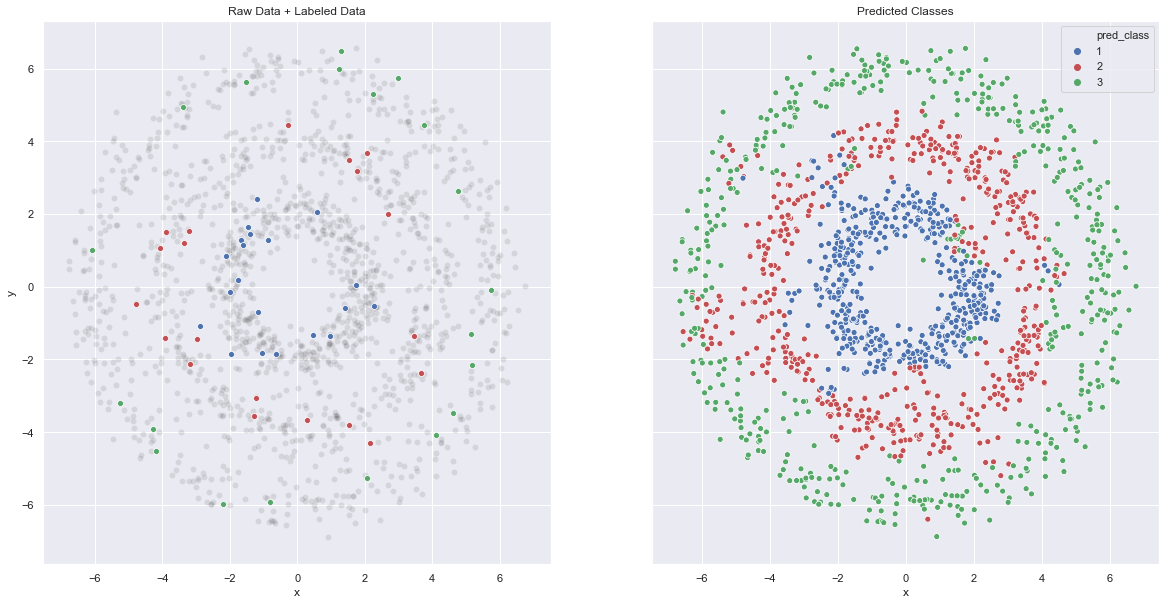

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))

sns.scatterplot(x=x1, y=y1, ax=ax1, color='k', alpha=0.1)
sns.scatterplot(x=x2, y=y2, ax=ax1, color='k', alpha=0.1)
sns.scatterplot(x=x3, y=y3, ax=ax1, color='k', alpha=0.1)

sns.scatterplot(x=q1, y=p1, ax=ax1, color='b')
sns.scatterplot(x=q2, y=p2, ax=ax1, color='r')
sns.scatterplot(x=q3, y=p3, ax=ax1, color='g')

ax1.set(title='Raw Data + Labeled Data', xlabel='x', ylabel='y')

sns.scatterplot(
    x='x',
    y='y', 
    data=data_df,
    hue='pred_class',  
    palette=['b', 'r', 'g'], 
    ax=ax2
)

ax2.set(title='Predicted Classes');

The results are pretty good! To conclude, this algorithm balances a given input of labels and local similarity based on the graph model (representation) of the data. For control on locality, the graph Laplacian (and its spectrum!) is a key ingredient. 